# Plots and figures for NAACL submission

In [14]:
fontsize = 30 # 60
linewidth = 2
lfontsize = int(fontsize*0.7)
figsize=7
save_path = "2_02_NAACL_plots_figures"
!mkdir 2_02_NAACL_plots_figures

mkdir: cannot create directory ‘2_02_NAACL_plots_figures’: File exists


In [212]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
%matplotlib inline

## Novelty evaluation

### Human evaluation instructions:

Rephrasing, same relation	1	
triplet that requires simple changes (morphology, removing words)
Rephrasing, different relation	2	
when triplet requiring rephrasing has different relation
Similar word, same relation	3	
when triplet has closely related word (e.g. live in, habit, or book/newspaper)
None of the above	4	
when none of the above
Simple inference	5	
when it requires inference from a single triplet. Common when similar phrasing, but different relation.
Knowledge	6	

Similar word, different relation	7	
subset of simple inference

In [23]:
"""
Plan:

Table with mean novelty for each dataset, # trivial, # novel, correlation distance

Table with histogram of novelty (categories on x axis)
"""

'\nPlan:\n\nTable with mean novelty for each dataset, # trivial, # novel, correlation distance\n'

In [206]:
novelty_dir = "/data/milatmp1/jastrzes/l2lwe/eval/novelty"
data = {
    "li-test": "test_sample100pos_closest_scored",
    "rand-train": "train_sample100_100k_closest_scored",
    "wiki-top10k": "tuples.wiki.top500_10k_closest_scored"
}

key_to_name = {
    "li-test": "High quality",
    "rand-train": "Random",
    "wiki-top10k": "Wiki"
}

In [200]:
code_to_category = {
    1: "same rel, rephrase",
    2: "different rel, rephrase",
    3: "same rel, similar word",
    4: "novel",
    5: "novel, simple inference",
    6: "knowledge",
    7: "different rel, similar word"
}

category_to_code = {v: k for k, v in code_to_category.iteritems()}

novelty_score = {
    "same rel, rephrase": 0,
    "different rel, rephrase": 1,
    "same rel, similar word": 2,
    "different rel, similar word": 3,
    "novel, simple inference": 4,
    "novel": 5
}

novelty_score_to_cat = {v: k for k, v in novelty_score.iteritems()}

In [101]:
import scipy
from scipy.stats import pearsonr

### Histogram

In [209]:
D = []
ordered_categories = [novelty_score_to_cat[v] for v in range(6)]

for k in data.keys():#["wiki-top10k"]:
    row = {}
    
    # Hacky read, make sure works
    A = pd.read_csv(os.path.join(novelty_dir, data[k] + ".tsv"), sep="\t", header=None)
    A.columns = ["T/F", "novelty category", "rel", "head", "tail"] + ["n" + str(id) for id in range(len(A.columns) - 5)]
    dists_path = os.path.join(novelty_dir, data[k] + ".tsv.dists").replace("_scored", "")
    dists = np.array([float(z) for z in open(dists_path).read().splitlines()])
    A['dist'] = dists
    A['T/F_casted'] = [0 if v=="F" else (1 if v=="F" else np.nan) for v in A['T/F'].values]
    assert len(A) == len(dists)
    
    # Subset
    print("Before subsetting {} {} rows".format(k, len(A)))
    sel = (np.isnan(A['T/F_casted'].values)) & (~np.isnan(A['novelty category'].values)) & (A['novelty category'].values != category_to_code['knowledge'])
    A = A[sel]
    print("After subsetting {} rows".format(len(A)))

    N = float(len(A))
    for cat in ordered_categories:
        row[cat] = int(sum(A['novelty category'].values == category_to_code[cat])/N*100)
    
    row = {k:"${0}$%".format(row[k]) for k in row}
    
    D.append(row)
    
D = pd.DataFrame(D, index=[key_to_name[k] for k in data.keys()])
D = D[ordered_categories]
D.columns = list("ABCDEF")

print D.to_latex().replace("\\textbackslash", "\\").replace("\\$", "$")

D

Before subsetting wiki-top10k 500 rows
After subsetting 34 rows
Before subsetting li-test 100 rows
After subsetting 95 rows
Before subsetting rand-train 100 rows
After subsetting 84 rows
\begin{tabular}{lllllll}
\toprule
{} &      A &      B &      C &     D &      E &      F \\
\midrule
Wiki         &  $14$\% &   $5$\% &  $17$\% &  $8$\% &   $8$\% &  $44$\% \\
High quality &  $65$\% &  $22$\% &   $4$\% &  $4$\% &   $2$\% &   $2$\% \\
Random       &  $21$\% &  $10$\% &  $16$\% &  $3$\% &  $17$\% &  $29$\% \\
\bottomrule
\end{tabular}



,A,B,C,D,E,F
Wiki,$14$%,$5$%,$17$%,$8$%,$8$%,$44$%
High quality,$65$%,$22$%,$4$%,$4$%,$2$%,$2$%
Random,$21$%,$10$%,$16$%,$3$%,$17$%,$29$%


### Mean novelty + correlation

In [211]:
D = []

for k in data.keys():#["wiki-top10k"]:
    row = {}
    
    # Hacky read, make sure works
    A = pd.read_csv(os.path.join(novelty_dir, data[k] + ".tsv"), sep="\t", header=None)
    A.columns = ["T/F", "novelty category", "rel", "head", "tail"] + ["n" + str(id) for id in range(len(A.columns) - 5)]
    dists_path = os.path.join(novelty_dir, data[k] + ".tsv.dists").replace("_scored", "")
    dists = np.array([float(z) for z in open(dists_path).read().splitlines()])
    A['dist'] = dists
    A['T/F_casted'] = [0 if v=="F" else (1 if v=="F" else np.nan) for v in A['T/F'].values]
    assert len(A) == len(dists)
    
    # Subset
    print("Before subsetting {} {} rows".format(k, len(A)))
    sel = (np.isnan(A['T/F_casted'].values)) & (~np.isnan(A['novelty category'].values)) & (A['novelty category'].values != category_to_code['knowledge'])
    A = A[sel]
    print("After subsetting {} rows".format(len(A)))

    # Extra processing
    A['novelty score'] = [novelty_score[code_to_category[v]] for v in A['novelty category']]
    
    # Add row
    row['Mean novelty'] = np.mean(A['novelty score'])
    row['Mean novelty (close)'] = np.mean(A['novelty score'].values[np.argsort(A['dist'])[0:(len(A)/2)]])
    row['Mean novelty (far)'] = np.mean(A['novelty score'].values[np.argsort(A['dist'])[(len(A)/2):]])
    row['Pearson correlation'] = pearsonr(A['novelty score'].values, A['dist'].values)[0]
    
    row = {k:"${0:.2f}$".format(row[k]) for k in row}
    
    D.append(row)
    
D = pd.DataFrame(D, index=[key_to_name[k] for k in data.keys()])

print D.to_latex().replace("\\textbackslash", "\\").replace("\\$", "$")

D

Before subsetting wiki-top10k 500 rows
After subsetting 34 rows
Before subsetting li-test 100 rows
After subsetting 95 rows
Before subsetting rand-train 100 rows
After subsetting 84 rows
\begin{tabular}{lllll}
\toprule
{} & Mean novelty & Mean novelty (close) & Mean novelty (far) & Pearson correlation \\
\midrule
Wiki         &       $3.24$ &               $2.47$ &             $4.00$ &              $0.47$ \\
High quality &       $0.62$ &               $0.49$ &             $0.75$ &              $0.22$ \\
Random       &       $2.75$ &               $2.17$ &             $3.33$ &              $0.30$ \\
\bottomrule
\end{tabular}



,Mean novelty,Mean novelty (close),Mean novelty (far),Pearson correlation
Wiki,$3.24$,$2.47$,$4.00$,$0.47$
High quality,$0.62$,$0.49$,$0.75$,$0.22$
Random,$2.75$,$2.17$,$3.33$,$0.30$


## Models select for novel examples

In [ ]:
"""
Data based on:

Bilinear AVG:
100 6.55929998312 1.55408313655 2.01434971313 10.6137199302
1000 6.2092080361 1.63795161145 2.59758217403 10.1716750275
10000 5.83753308128 2.04132890873 0.0 10.0215769034
100000 5.76031281058 1.82849869091 1.87070485377 9.9147492036
1000000 5.88307964427 2.09135583904 2.96670636949 11.951794344

Prototypical
--
100 7.96347576215 1.70557050395 4.04987467302 10.7852191478
1000 6.90560373882 2.07038575489 2.05574725 11.3117595532
10000 6.01117001778 2.00991527102 2.21324647341 10.7992605036
100000 5.3410484093 1.53847560579 2.19548225849 10.6464093284
1000000 5.8649856933 2.017441234 2.76355051571 12.3994254923


, which is output from 25_12_wiki_subsample.ipynb
"""

In [21]:
data = {
    "prototypical": [7.96, 6.90, 6.11, 5.34, 5.586],
    "bilinear": [6.55, 6.20, 5.83, 5.76, 5.88]
}

ranges = [100, 1000, 10000, 100000, 1000000]

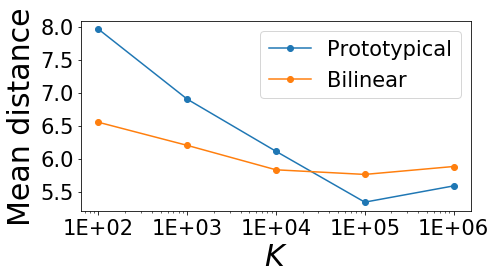

In [22]:
plt.figure(figsize=(figsize, 0.5*figsize))

plt.plot(ranges, data['prototypical'], label="Prototypical", marker="o", linestyle="-")
plt.plot(ranges, data['bilinear'], label="Bilinear", marker="o", linestyle="-")

ax = plt.gca()

ax.set_ylabel("Mean distance",fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel("$K$", fontsize=fontsize)

ax.set_yticklabels(["{:.1f}".format(xx) for id_x, xx in enumerate(ax.get_yticks())],fontsize=lfontsize)
ax.set_xticklabels(["{:.0E}".format(xx) for id_x, xx in enumerate(ax.get_xticks())],fontsize=lfontsize)

plt.legend(fontsize=lfontsize)
plt.savefig(os.path.join(save_path, "top_k_dist.pdf"), bbox_inches='tight')  

# CN-completion results

Idea: b1/b2/b3 

row: model
column: dataset (all) dataset( split)

In [142]:
DATA_DIR = "/data/milatmp1/jastrzes/l2lwe/data"
test = pd.read_csv(os.path.join(DATA_DIR, "ACL/conceptnet/test.txt"), sep="\t", header=None)
test.columns = ['rel', 'head', 'tail', 'score']

In [193]:
from sklearn.metrics import f1_score

In [187]:
from os.path import join
import json

factorized_dir = "/data/milatmp1/jastrzes/l2lwe/results/factorized/"
dnn_dir = "/data/milatmp1/jastrzes/l2lwe/results/dnn_ce/"

data_li = {
    "prototypical": join(factorized_dir, "3_01_prototypical_conceptnet_my"),
    "prototypical + glove": join(factorized_dir, "3_01_prototypical_conceptnet_my_glove_3"),
    "factorized": join(factorized_dir, "3_01_root_conceptnet_my_2"),
    "factorized + glove": join(factorized_dir, "3_01_root_conceptnet_my_glove_2"),
    "DNN": join(dnn_dir, "3_01_root_conceptnet_my"),
    "DNN + glove": join(dnn_dir, "3_01_root_conceptnet_my_glove")
}

data_random = {
    "prototypical": join(factorized_dir, "3_01_prototypical_conceptnet_my_random_100k"),
    "prototypical + glove": join(factorized_dir, "3_01_prototypical_conceptnet_my_random_100k_glove_3"),
    "factorized": join(factorized_dir, "2_01_root_conceptnet_my_random_100k"),
    "factorized + glove": join(factorized_dir, "3_01_root_conceptnet_my_random_100k_glove"),
    "DNN": join(dnn_dir, "3_01_root_conceptnet_my_random_100k"),
    "DNN + glove": join(dnn_dir, "3_01_root_conceptnet_my_random_100k_glove")
}

datasets = {"li": data_li, "random": data_random}

In [196]:
D = []
assert data_li.keys() == data_random.keys()
for model in data_li.keys():
    row = {}
    
    # Columns
    for dataset in ['random']:
        print(path)
        path = join(datasets[dataset][model], "eval_results.json")
        cpath = join(datasets[dataset][model], "config.json") 
        
        if os.path.exists(path):
            
            # Read
            scores = json.load(open(path))
            c = json.load(open(cpath))
            distpath = join(c['data_dir'], "test.txt.dists")
            
            
            # Normal acc
            row[dataset] = "${0:.3f}$".format(scores['test_thr_acc'])
            
            if os.path.exists(distpath):
                dists = np.array([float(v) for v in open(distpath).read().splitlines()])
                # Bucket acc
                dist_id = np.argsort(dists)
                K = len(dist_id)/3
                bucket_scores = []
                for id in range(3):
                    bucket = dist_id[id*K:(id+1)*K]
                    bucket_scores.append("${0:.3f}$".format(f1_score(test.score.values[bucket], 
                        np.array(scores['scores_test'])[bucket] >= scores['threshold']))) # scores['test_thr_acc']

                row[dataset + "(buckets)"] = " / ".join(bucket_scores)
            
        else:
            row[dataset] = 0
        
        
        # TODO: Add split based
        
    D.append(row)
    
D = pd.DataFrame(D, index=data_li.keys())
print D.to_latex().replace("\\textbackslash", "\\").replace("\\$", "$")
D

/data/milatmp1/jastrzes/l2lwe/results/factorized/3_01_prototypical_conceptnet_my/eval_results.json
/data/milatmp1/jastrzes/l2lwe/results/factorized/2_01_root_conceptnet_my_random_100k/eval_results.json
/data/milatmp1/jastrzes/l2lwe/results/dnn_ce/3_01_root_conceptnet_my_random_100k_glove/eval_results.json
/data/milatmp1/jastrzes/l2lwe/results/dnn_ce/3_01_root_conceptnet_my_random_100k/eval_results.json
/data/milatmp1/jastrzes/l2lwe/results/factorized/3_01_prototypical_conceptnet_my_random_100k_glove_3/eval_results.json
/data/milatmp1/jastrzes/l2lwe/results/factorized/3_01_root_conceptnet_my_random_100k_glove/eval_results.json
\begin{tabular}{lll}
\toprule
{} &   random &              random(buckets) \\
\midrule
factorized           &  $0.822$ &  $0.874$ / $0.812$ / $0.731$ \\
DNN + glove          &  $0.789$ &  $0.868$ / $0.772$ / $0.695$ \\
DNN                  &  $0.809$ &  $0.883$ / $0.809$ / $0.725$ \\
prototypical + glove &  $0.756$ &  $0.871$ / $0.734$ / $0.632$ \\
factorized + gl

,random,random(buckets)
factorized,$0.822$,$0.874$ / $0.812$ / $0.731$
DNN + glove,$0.789$,$0.868$ / $0.772$ / $0.695$
DNN,$0.809$,$0.883$ / $0.809$ / $0.725$
prototypical + glove,$0.756$,$0.871$ / $0.734$ / $0.632$
factorized + glove,$0.799$,$0.869$ / $0.788$ / $0.669$
prototypical,$0.755$,$0.866$ / $0.758$ / $0.674$


# Li evaluation on wiki results

Scored by Stan and Arian, Bilinear vs factorized vs prototypical.

Column is model, single row

In [232]:
from collections import defaultdict
import json

In [ ]:
"""
For future reference.

Script used to get results:

python scripts/evaluate/human_evaluate_triplets_v2.py evaluate 
/data/milatmp1/jastrzes/l2lwe/eval/1/mapping_1.csv /data/milatmp1/jastrzes/l2lwe/eval/1/eval_1_done_stan.tsv  
/data/milatmp1/jastrzes/l2lwe/eval/1/eval_results.json

python scripts/evaluate/human_evaluate_triplets_v2.py evaluate 
/data/milatmp1/jastrzes/l2lwe/eval/2/mapping_2.csv /data/milatmp1/jastrzes/l2lwe/eval/2/eval_2_done_stan.csv  
/data/milatmp1/jastrzes/l2lwe/eval/2/eval_results.json

python scripts/evaluate/human_evaluate_triplets_v2.py evaluate 
/data/milatmp1/jastrzes/l2lwe/eval/1/mapping_2.csv /data/milatmp1/jastrzes/l2lwe/eval/1/eval_1_done_arian.csv  
/data/milatmp1/jastrzes/l2lwe/eval/1/eval_results_arian.json

python scripts/evaluate/human_evaluate_triplets_v2.py evaluate 
/data/milatmp1/jastrzes/l2lwe/eval/2/mapping_2.csv /data/milatmp1/jastrzes/l2lwe/eval/2/eval_2_done_arian.csv  
/data/milatmp1/jastrzes/l2lwe/eval/2/eval_results_arian.json
"""

In [240]:
# Configuration
evals = ["/data/milatmp1/jastrzes/l2lwe/eval/1/eval_results.json", 
         "/data/milatmp1/jastrzes/l2lwe/eval/2/eval_results.json",
        "/data/milatmp1/jastrzes/l2lwe/eval/1/eval_results_arian.json", 
         "/data/milatmp1/jastrzes/l2lwe/eval/2/eval_results_arian.json"]

modelname_to_tablename = {
    "12_11_prototypical": "Prototypical",
    "LiACL": "Bilinear",
    "13_11_root": "Factorized"
}

def get_modelname(name):
    return name.split("/")[-3]

In [258]:
# Small script to compute the table
D = defaultdict(list)
for E in evals:
    # Assumed keys: "A", "B" and "key_to_name"
    R = json.load(open(E))
    assert "A" in R; assert "B" in R; assert "key_to_name" in R
    # HACK: Assumption that keys are A or B
    for key in ['A', 'B']:
        modelname = get_modelname(R['key_to_name'][key])
        if modelname in modelname_to_tablename:
            D[modelname_to_tablename[modelname]].append(R[key])

D = {tablename: "{0:.2f}".format(np.mean(D[tablename])) for tablename in D}
D = pd.DataFrame({"Wiki top 100": D}).T
print D.to_latex().replace("\\textbackslash", "\\").replace("\\$", "$")
D

\begin{tabular}{llll}
\toprule
{} & Bilinear & Factorized & Prototypical \\
\midrule
Wiki top 100 &     1.78 &       1.96 &         2.00 \\
\bottomrule
\end{tabular}



,Bilinear,Factorized,Prototypical
Wiki top 100,1.78,1.96,2.00


### Inter-agreement

In [229]:
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import cohen_kappa_score

In [222]:
scores_arian = ["/data/milatmp1/jastrzes/l2lwe/eval/1/eval_1_done_arian.csv", "/data/milatmp1/jastrzes/l2lwe/eval/2/eval_2_done_arian.csv"]
scores_stan = ["/data/milatmp1/jastrzes/l2lwe/eval/1/eval_1_done_stan.tsv", "/data/milatmp1/jastrzes/l2lwe/eval/2/eval_2_done_stan.csv"]

In [223]:
# Small hacky code to read floats from csv/tsv
for S in [scores_arian, scores_stan]:
    for id in range(len(S)):
        if S[id].endswith("tsv"):
            S[id] = pd.read_csv(S[id], sep="\t")['score'].values
        else:
            S[id] = pd.read_csv(S[id])['score'].values
scores_arian = np.array(scores_arian).reshape(-1,)
scores_stan = np.array(scores_stan).reshape(-1,)

In [230]:
print pearsonr(scores_arian, scores_stan)
print cohen_kappa_score(scores_arian, scores_stan)

(0.8191557554970329, 4.0324523289756378e-98)
0.488704955932


# Bucketed wiki results

Code used to compute eval_results.json's: 

In [265]:
"""
for i in 0 1 2; do; python scripts/evaluate/human_evaluate_triplets_v2.py evaluate /data/milatmp1/jastrzes/l2lwe/eval/arian/7__b0.txt/mapping_7__b0.txt.csv /data/milatmp1/jastrzes/l2lwe/eval/arian/7__b0.txt/eval_7__b0.txt.csv  /data/milatmp1/jastrzes/l2lwe/eval/arian/7__b${.txt/eval_results.json; done
"""

'\nfor i in 0 1 2; do; python scripts/evaluate/human_evaluate_triplets_v2.py evaluate /data/milatmp1/jastrzes/l2lwe/eval/arian/7__b0.txt/mapping_7__b0.txt.csv /data/milatmp1/jastrzes/l2lwe/eval/arian/7__b0.txt/eval_7__b0.txt.csv  /data/milatmp1/jastrzes/l2lwe/eval/arian/7__b${.txt/eval_results.json; done\n'

In [275]:
evals = ["/data/milatmp1/jastrzes/l2lwe/eval/arian/7__b0.txt/eval_results.json", 
         "/data/milatmp1/jastrzes/l2lwe/eval/arian/7__b1.txt/eval_results.json",
        "/data/milatmp1/jastrzes/l2lwe/eval/arian/7__b2.txt/eval_results.json"]

def get_modelname(name):
    return name.split("/")[-3]

def get_evalname(name):
    return name.split("/")[-2]

modelname_to_tablename = {
    "3_01_prototypical_conceptnet_my": "Prototypical",
    "3_01_root_conceptnet_my_2": "Factorized",
    "3_01_root_conceptnet_my": "DNN"
}

evalname_to_tablename = {
    "7__b0.txt": "$[0%, 33%]$",
    "7__b1.txt": "$(33%, 66%]$",
    "7__b2.txt": "$(66%, 100%]$",
}


In [278]:

# Small script to compute the table
# Row is here bucket, column model. Will transpose later
D = []
D_index = []

for E in evals:
    row = {}
    evalname = get_evalname(E)
    
    # Assumed keys: "A", "B" and "key_to_name"
    R = json.load(open(E))
    assert "0" in R; assert "1" in R; assert "2" in R; assert "key_to_name" in R
    # HACK: Assumption that keys are A or B
    for key in ['0', '1', '2']:
        modelname = get_modelname(R['key_to_name'][key])
        if modelname in modelname_to_tablename:
            row[modelname_to_tablename[modelname]] = "${0:.2f}$".format(R[key])
    
    # Populate
    D.append(row)
    D_index.append(evalname_to_tablename[evalname])

D = pd.DataFrame(D, index=D_index).T
print D.to_latex().replace("\\textbackslash", "\\").replace("\\$", "$")
D

\begin{tabular}{llll}
\toprule
{} & $[0\\%, 33\\%]$ & $(33\\%, 66\\%]$ & $(66,\%, 100\\%]$ \\
\midrule
DNN          &        $2.47$ &         $2.34$ &          $1.41$ \\
Factorized   &        $2.57$ &         $2.12$ &          $2.24$ \\
Prototypical &        $2.33$ &         $2.24$ &          $1.63$ \\
\bottomrule
\end{tabular}



,"$[0\%, 33\%]$","$(33\%, 66\%]$","$(66,%, 100\%]$"
DNN,$2.47$,$2.34$,$1.41$
Factorized,$2.57$,$2.12$,$2.24$
Prototypical,$2.33$,$2.24$,$1.63$


# Error analysis

Are results correctable?